In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

## Callbacks

### Callbacks as GUI events

In [3]:
import ipywidgets as widgets

In [4]:
def f(o): print('hi')
w = widgets.Button(description = 'Click me!')
w.on_click(f)

In [5]:
w

Button(description='Click me!', style=ButtonStyle())

hi
hi
hi


*NB: When callbacks are used in this way they are often called "events".*

Did you know what you can create interactive apps in Jupyter with these widgets? Here's an example from [plotly](https://plot.ly/python/widget-app/):

![](https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif)

### Creating your own callback

In [6]:
from time import sleep

In [7]:
def slow_calculation(cb=None):
    res=0
    for i in range(5):
        res += i*i
        if cb:cb(i)
    return res

In [8]:
slow_calculation(lambda o: print(f"Awesome We've finished epoch {o}"))

Awesome We've finished epoch 0
Awesome We've finished epoch 1
Awesome We've finished epoch 2
Awesome We've finished epoch 3
Awesome We've finished epoch 4


30

In [9]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}")
    

In [10]:
slow_calculation(lambda o: show_progress("ok i guess", o))

ok i guess! We've finished epoch 0
ok i guess! We've finished epoch 1
ok i guess! We've finished epoch 2
ok i guess! We've finished epoch 3
ok i guess! We've finished epoch 4


30

In [11]:
def make_show_progess(exclamation):
    # leading '_' is generally understood to be "private"
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}")
    return _inner

In [12]:
slow_calculation(make_show_progess("Nice!"))

Nice!! We've finished epoch 0
Nice!! We've finished epoch 1
Nice!! We've finished epoch 2
Nice!! We've finished epoch 3
Nice!! We've finished epoch 4


30

In [13]:
def make_show_progess(exclamation):
    # leading '_' is generally understood to be "private"
    def _inner(epoch): print(f"{exclamation}! We've finished epoch {epoch}")
    return _inner

This thing where you create a fn that stores info from an external context(like it can be different everytime) is called a closure.

In [15]:
slow_calculation(make_show_progess("BOOYAH!"))

BOOYAH!! We've finished epoch 0
BOOYAH!! We've finished epoch 1
BOOYAH!! We've finished epoch 2
BOOYAH!! We've finished epoch 3
BOOYAH!! We've finished epoch 4


30

In [16]:
f2 = make_show_progess("BOOYAH!")
slow_calculation(f2)

BOOYAH!! We've finished epoch 0
BOOYAH!! We've finished epoch 1
BOOYAH!! We've finished epoch 2
BOOYAH!! We've finished epoch 3
BOOYAH!! We've finished epoch 4


30

In [17]:
from functools import partial
slow_calculation(partial(show_progress, 'Ok i guess'))

Ok i guess! We've finished epoch 0
Ok i guess! We've finished epoch 1
Ok i guess! We've finished epoch 2
Ok i guess! We've finished epoch 3
Ok i guess! We've finished epoch 4


30

### Callbacks as callable classes

In [18]:
class ProgressShowCallback():
    def __init__(self, exclamation='Awesome'): self.exclamation = exclamation
    # dunder call is used so that you can use a class as a function
    def __call__(self, epoch): print(f"{self.exclamation}! We've finished epoch {epoch}")

In [20]:
cb = ProgressShowCallback("Super")

In [22]:
cb('hi')

Super! We've finished epoch hi


In [21]:
slow_calculation(cb)

Super! We've finished epoch 0
Super! We've finished epoch 1
Super! We've finished epoch 2
Super! We've finished epoch 3
Super! We've finished epoch 4


30

### Multiple callback funcs; `*args` and `**kwargs`

In [23]:
def f(*args, **kwargs): print(f"{args} ; {kwargs}")

In [24]:
a = [1,2,3,4]
b = 'sdasd'
f(3, 'a', a, b, thing1= 'hello')

(3, 'a', [1, 2, 3, 4], 'sdasd') ; {'thing1': 'hello'}


positional arguments end up in args & keyword arguments end up in kwargs.

NB: We've been guilty of over-using kwargs in fastai - it's very convenient for the developer, but is annoying for the end-user unless care is taken to ensure docs show all kwargs too. kwargs can also hide bugs (because it might not tell you about a typo in a param name). In [R](https://www.r-project.org/) there's a very similar issue (R uses `...` for the same thing), and matplotlib uses kwargs a lot too.

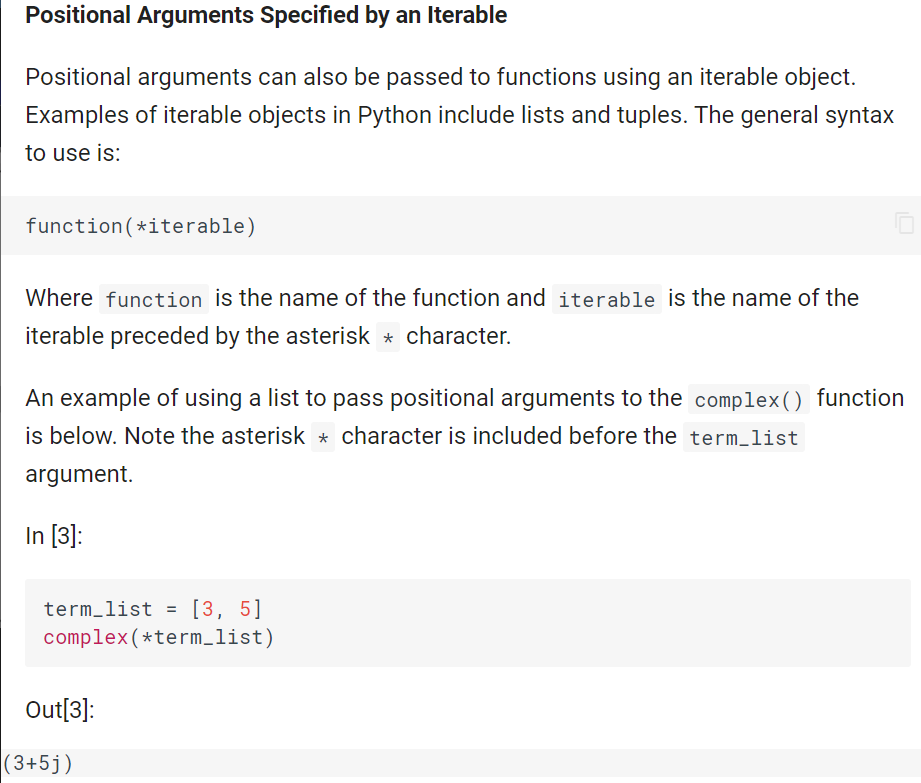

In [25]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [27]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print(f"About to start")
    def after_calc (self, *args, **kwargs): print(f"Done step")

In [28]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [29]:
class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs): print(f"About to start: {epoch}")
    def after_calc (self, epoch, val, **kwargs): print(f"After {epoch}: {val}")

In [30]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

## Modifying behaviour

In [31]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        # hasattr has 2 parameters: object and its name.
        if cb and hasattr(cb, 'before_calc'): cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'):
            if cb.after_calc(i, res):
                print('Stopping early')
                break
    return res

In [32]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val>10: return True

Notice that we haven't defined a before_calc callback but no error is being returned This is because we first check that such a callback exists before calling it.

In [33]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
Stopping early


14

What if you wanna change the way that the calculation is being done? You could definitely do that. Take you calculation() and put it into a class and so the value that it would calculate will be an attribute of the class and so you could define a callback that reaches back inside the calculator, grabs that variable and changes it.

In [34]:
class SLowCalculator():
    def __init__(self, cb=None): self.cb, self.res = cb, 0
    
    def callback(self, cb_name, *args): 
        if not self.cb: return # checks to see if a cb is defined
        cb = getattr(self.cb, cb_name, None) # if it is, then it grabs it
        if cb: return cb(self, *args) # then calls  it, passing in the calculator object in self
        
    def calc(self):
        for i in range(5):
            self.callback('before calc', i)# calls the callback function above  
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print('stopping early')
                break

Instead of callback() you replace it with a  dunder __call__ then you can simply <span class="mark">replace self.callback('blah blah') to self('blah blah').</span>  
THIS is what was done by jeremy and team in the last refactoring of the callback class. Finally you understand almost all of it(?) 

In [35]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f"after {epoch}: {calc.res}")
        if calc.res >10: return True
        if calc.res<3: calc.res = calc.res*1.5

In [36]:
cal = SLowCalculator(ModifyingCallback())

In [37]:
cal

In [38]:
cal.calc() # run the function calc in the class
cal.res # print final value of res

after 0: 0
after 1: 1.0
after 2: 5.5
after 3: 14.5
stopping early


14.5

This is the most flexible callback system

## `__dunder__` thingies

Anything that looks like `__this__` is, in some way, *special*. Python, or some library, can define some functions that they will call at certain documented times. For instance, when your class is setting up a new object, python will call `__init__`. These are defined as part of the python [data model](https://docs.python.org/3/reference/datamodel.html#object.__init__).

For instance, if python sees `+`, then it will call the special method `__add__`. If you try to display an object in Jupyter (or lots of other places in Python) it will call `__repr__`.

In [45]:
class SloppyAdder():
    def __init__(self, o): self.o= o
    def __add__(self, b): 
        #print(b.o)
        return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self): return str(self.o)

In [46]:
a = SloppyAdder(1)
b= SloppyAdder(2)
a+b

3.01

In [48]:
a, b

(1, 2)

Special methods you should probably know about (see data model link above) are:

- `__getitem__`
- `__getattr__`
- `__setattr__`
- `__del__`
- `__init__`
- `__new__`
- `__enter__`
- `__exit__`
- `__len__`
- `__repr__`
- `__str__`

## Variance and stuff

### Variance

In [49]:
t = torch.tensor([1.,2.,4.,18])

In [50]:
m = t.mean(); m

tensor(6.2500)

In [52]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [53]:
(t-m).pow(2).mean()

tensor(47.1875)

In [54]:
(t-m).abs().mean() # calculate mean absolute deviation

tensor(5.8750)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [55]:
(t-m).pow(2).mean().sqrt() # std

tensor(6.8693)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. <span class="mark">However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.</span>

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.  
  
STD is more sensitive to outliers than mean absoluted deviation.In Machine learning, you wana be using mean absolute deviation most of the time because outliers are more of a problem than help.


Here's a useful thing to note about variance:

In [56]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance and correlation

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

In [57]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code. So now we need two vectors.

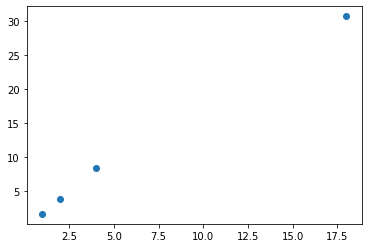

In [74]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [75]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 49.8518,  31.1250,   6.0610, 229.2764])

In [76]:
prod.mean()

tensor(79.0785)

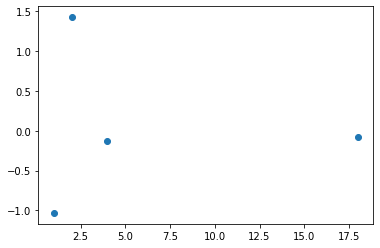

In [77]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [78]:
((t-t.mean())*(v-v.mean())).mean() # covariance

tensor(-0.3158)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [79]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-0.3158)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [80]:
cov/(t.std() * v.std())

tensor(-0.0392)

It's just a scaled version of the same thing. Question: *Why is it scaled by standard deviation, and not by variance or mean or something else?*

## Softmax

Here's our final `logsoftmax` definition:

In [81]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$ 

And our cross entropy loss is:
$$-\log(p_{i})$$

## Browsing source code

- Jump to tag/symbol by with (with completions)
- Jump to current tag
- Jump to library tags
- Go back
- Search
- Outlining / folding